In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

In [105]:
lcs = utils.get_data('../datasets/ZTF_g', sep=',', start_col=1, batch_size=1, min_length=1, n_union_tp=3500, num_resamples=0,shuffle=True, split=1.0, extend=0)


validated 3408 files out of 3408 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (2559, 1, 1974, 3)
train size: 2559, valid size: 0, test size: 0


In [106]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('./checkpoints/ZTF_g0.668415367603302.h5', lcs.data_obj)


=> loading checkpoint './checkpoints/ZTF_g0.668415367603302.h5'
Namespace(n_union_tp=3500, data_folder='datasets/ZTF_g', checkpoint='datasets/ZTF_g0.7037358283996582.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=30, patience=100, early_stopping=False, niters=20000, frac=0.5, batch_size=2, mse_weight=5.0, dropout=0.0, num_resamples=0, lr=1e-06, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=2, save=True, k_iwae=1)


In [107]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:27<00:00, 93.47it/s]


In [108]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)

In [109]:

n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

In [110]:
print(zs.shape,disc_path.shape)

(2559, 16, 64) (2559, 16, 64)


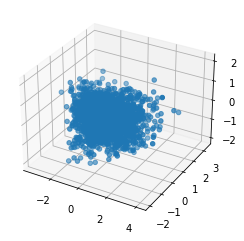

In [111]:
RS = 20150101
pca = PCA(n_components=3, random_state=RS)
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])

In [112]:
pca.explained_variance_ratio_

array([0.00977394, 0.00369201, 0.00291501])

(array([  6.,  48., 228., 617., 834., 461., 241., 102.,  16.]),
 array([-3.42062659, -2.66748316, -1.91433973, -1.16119629, -0.40805286,
         0.34509057,  1.098234  ,  1.85137743,  2.60452086,  3.35766429]),
 <BarContainer object of 9 artists>)

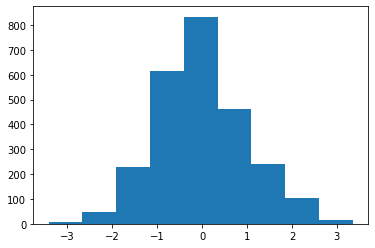

In [113]:
r1,r2 = np.min(pca3d[:,0]), np.max(pca3d[:,0])
bins = np.arange(r1,r2, step=(r2-r1)/10)
plt.hist(pca3d[:,0],bins=bins)

In [114]:
bin_i = np.digitize(pca3d[:,0],bins=bins)

In [115]:
### avg qzs and disc encodings for each bin in the space 
avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
 for i in range(1,len(bins)+1)]
avgs = np.array(avgs,dtype=np.float32)

In [130]:
target_tp = np.arange(0,1500,step=3, dtype=np.float32)
target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins),axis=0)

In [132]:
interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.95it/s]


In [133]:
interps.shape

(10, 1, 500, 3)

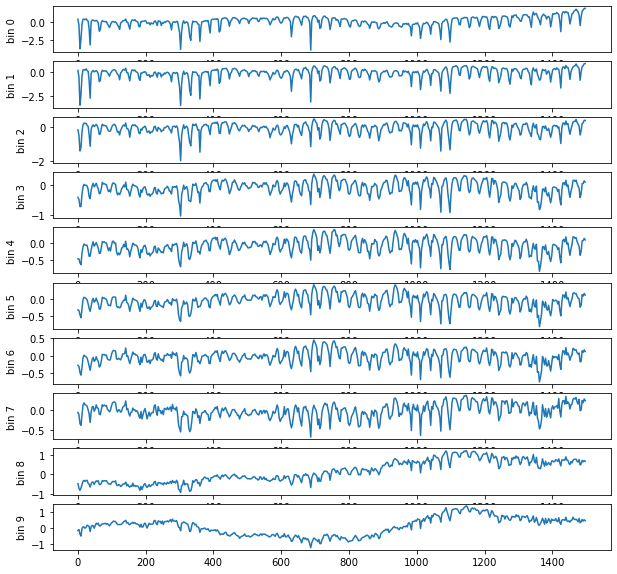

In [135]:
n=len(interps)
dims = len(lcs.bands)
figsize=(10,10)
fig,ax = plt.subplots(n,dims,figsize=figsize, squeeze=False)
for ex in range(N):
    ax[ex,0].set_ylabel(f'bin {ex}')
    for band in range(dims):
        ax[ex,band].plot(interps[ex,band,:,0],interps[ex,band,:,1])